# Udacity's Introduction to Data Science Final Project


## NYC Subway Dataset Analysis Result 

This notebook demonstrates the workflow of analyzing the NYC Subway Dataset and the process of develping the final regression model. This notebook walks you through how I select features to be used for the regression model. 

Before you go on, I would like you to be aware the followings:
* The original subway data were obtained from NYC MTA website in text files. As part of the class activity, the data were cleaned up and saved in csv files. 

* Weather dataset were obtained from Weather Underground Website, and joined with the subway dataset.

* The NYC Subway Dataset only includes information for May 2011.

* The scope of the analysis is very limited for the sake of this project, which is to provide an opportunity to apply data sciecne to real work problem. However the pipeline will be improved continously to broaden the scope and provide a better insight of the NYC Subway ridership.



**Without further ado, let's get started**
### Import Libraries

In [171]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats
import numpy as np
from sklearn import datasets, linear_model

### 1. Acquire Data

In [172]:
def acquire_data(file):
    """
    Convert csv file to pandas dataframe
    """
    
    return pandas.read_csv(file)

nysw_df = acquire_data("Data/turnstile_weather_v2.csv")

### 2. Explore Data

In [173]:
def explore_data(df):
    """
    Explore data type and range
    """
    
    print("Showing dataframe columns\n")
    print(df.columns.values)
    print("")
    print("Showing first five records\n")
    print(df.head())
    print("")
    print("Showing last five records\n")
    print(df.tail())
    print("")
    print("Showing the distribution of numerical feature values")
    print(df.describe())

explore_data(nysw_df)    

Showing dataframe columns

['UNIT' 'DATEn' 'TIMEn' 'ENTRIESn' 'EXITSn' 'ENTRIESn_hourly'
 'EXITSn_hourly' 'datetime' 'hour' 'day_week' 'weekday' 'station'
 'latitude' 'longitude' 'conds' 'fog' 'precipi' 'pressurei' 'rain' 'tempi'
 'wspdi' 'meanprecipi' 'meanpressurei' 'meantempi' 'meanwspdi'
 'weather_lat' 'weather_lon']

Showing first five records

   UNIT     DATEn     TIMEn  ENTRIESn   EXITSn  ENTRIESn_hourly  \
0  R003  05-01-11  00:00:00   4388333  2911002              0.0   
1  R003  05-01-11  04:00:00   4388333  2911002              0.0   
2  R003  05-01-11  12:00:00   4388333  2911002              0.0   
3  R003  05-01-11  16:00:00   4388333  2911002              0.0   
4  R003  05-01-11  20:00:00   4388333  2911002              0.0   

   EXITSn_hourly             datetime  hour  day_week     ...       pressurei  \
0            0.0  2011-05-01 00:00:00     0         6     ...           30.22   
1            0.0  2011-05-01 04:00:00     4         6     ...           30.25   
2 

## 3. Clean Data
The subway dataset includes duplicate and irrelevant information. So the next step is to clean up the data.
I also converted mean temperature (meantempi) and mean wind speed (meanwspdi) from numerical to ordianl since high precision for these data are not neccessary. It is very unlike that one degree tempearue difference would make much difference on ridership.

In [174]:
def clean_data(df):
    """
    Only keep useful information and delete duplicate information
    Convert to ordinal data for daily average temperature and daily average wind speed
    """
    
    df = df[['UNIT', 'DATEn', 'TIMEn', 'ENTRIESn_hourly', 'datetime', 'hour', 'day_week', 'weekday',
              'station', 'rain', 'fog', 'meanprecipi', 'meantempi', 'meanwspdi']]
    df=df.rename(columns = {'ENTRIESn_hourly':'Entries_per_4_hours'})
    
    df.loc[df['meantempi'] < 60, 'meantempi'] = 1
    df.loc[(df['meantempi'] >= 60) & (df['meantempi'] < 70), 'meantempi'] = 2
    df.loc[df['meantempi'] >= 70, 'meantempi'] = 3
    
    df.loc[df['meanwspdi'] < 4, 'meanwspdi'] = 1
    df.loc[(df['meanwspdi'] >= 4) & (df['meanwspdi'] < 6), 'meanwspdi'] = 2
    df.loc[(df['meanwspdi'] >= 6) & (df['meanwspdi'] < 8), 'meanwspdi'] = 3
    df.loc[df['meanwspdi'] >= 8, 'meanwspdi'] = 4
    return df

nysw_df = clean_data(nysw_df)
explore_data(nysw_df)

Showing dataframe columns

['UNIT' 'DATEn' 'TIMEn' 'Entries_per_4_hours' 'datetime' 'hour' 'day_week'
 'weekday' 'station' 'rain' 'fog' 'meanprecipi' 'meantempi' 'meanwspdi']

Showing first five records

   UNIT     DATEn     TIMEn  Entries_per_4_hours             datetime  hour  \
0  R003  05-01-11  00:00:00                  0.0  2011-05-01 00:00:00     0   
1  R003  05-01-11  04:00:00                  0.0  2011-05-01 04:00:00     4   
2  R003  05-01-11  12:00:00                  0.0  2011-05-01 12:00:00    12   
3  R003  05-01-11  16:00:00                  0.0  2011-05-01 16:00:00    16   
4  R003  05-01-11  20:00:00                  0.0  2011-05-01 20:00:00    20   

   day_week  weekday        station  rain  fog  meanprecipi  meantempi  \
0         6        0  CYPRESS HILLS     0    0          0.0        1.0   
1         6        0  CYPRESS HILLS     0    0          0.0        1.0   
2         6        0  CYPRESS HILLS     0    0          0.0        1.0   
3         6        0  CYP

## 3. Pivot Features
The next step is to study which features to be included in the regression model. In order to do so statisitical tests are used to exam the null hypothesis. I'm interested to find out the followings.

#### Ridership Visualization

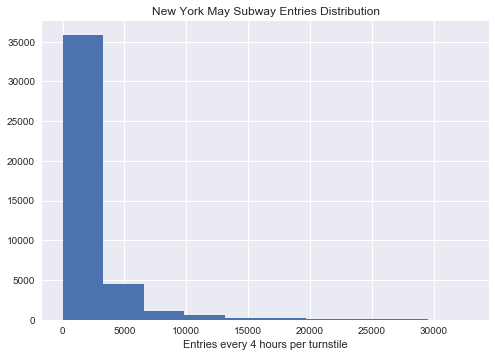

In [175]:
plt.hist(nysw_df['Entries_per_4_hours'])
plt.title('New York May Subway Entries Distribution')
plt.xlabel('Entries every 4 hours per turnstile')
plt.show()

Above histogram shows that the New York Subway entires in May is not normally distributed. The distribution is also long-tailed. When buiding the final regression model, a different model might be needed to better fit the outliners. The other approach is to convert variable scale, for example from linear to logarithmic.

Since the ridership distribution is not normally distributed, Mann Whitney Test is used to test the null hypothesis.

In [176]:
def mann_whitney_plus_means(dist1, dist2):
    """
    Perform Mann Whitness Test for Non-Normally Distributed data
    """
    
    mean1 = np.mean(dist1)
    mean2 = np.mean(dist2)
    U,p = scipy.stats.mannwhitneyu(dist1, dist2)
    return mean1, mean2, U, p

#### How does rain affect the ridership?
One of the hypothesis is that rain would change the ridership outcome. It is possible that when raining people would choose to take subway instead of walking; or choose to take taxi instead of subway. Either way the hypothesis is that rain would affect the number of people ride the subway. 
Plots below are to compare the two distribution.

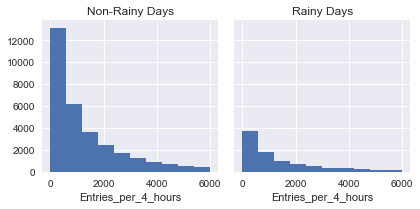

In [177]:
def rain_effect(dataframe): 
    """
    Compare entries distribution between rainy days and non-rainy days
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
    
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='rain')
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    plt.subplots_adjust(top=0.9)
    #plot.fig.suptitle('Compare Entries Distribution on Rainy Days and Non Rainy Days')
    axes = plot.axes.flatten()
    axes[0].set_title("Non-Rainy Days")
    axes[1].set_title("Rainy Days")
    
    #Mann Whitney Test
    nrain_mean, rain_mean, U, p = mann_whitney_plus_means(dataframe[dataframe['rain'] == 0]['Entries_per_4_hours'], 
                                                          dataframe[dataframe['rain'] == 1]['Entries_per_4_hours'])
    
    return nrain_mean, rain_mean, U, p

nrain_mean, rain_mean, U, p = rain_effect(nysw_df)
plt.show()

There are less rainy days in the dataset, therefore histogram for rainy day ridership shows less count. It is hard to tell if they are indeed  from the same distribution or not visually. Therefore a null hypothesis that both set of data are from the same distribution is set up. If a statistical test is able to reject the null hypothesis, it show rain indeed changes the ridership behavor.
A two tailed Mann Whitney Test is used to test the null hypothesis. Mann Whitney Test instead of T-Test is used because data is not normally distributed. The p-critical value to reject the null hypothesis is 5%. 

In [178]:
print('Average entries per 4 hours per turnstile on non-rainy days is %6.2f.' %nrain_mean, '\n')
print('Average entries per 4 hours per turnstile on rainy days  %6.2f.' %rain_mean, '\n')
print('The probability they are from the same distribution is %0.6f' %(p*100),'%.', '\n')
if p <= 0.05:
    print('Therefore rain affects the ridership outcome.')
else:
    print('Therefore rain does not affects the ridership outcome.')

Average entries per 4 hours per turnstile on non-rainy days is 1845.54. 

Average entries per 4 hours per turnstile on rainy days  2028.20. 

The probability they are from the same distribution is 0.000274 %. 

Therefore rain affects the ridership outcome.


#### How does rain affect the ridership differently between weekend and weekday?

Mann Whitney test rejected the null hypothesis with p value of 0.000274%. It shows that rain has a strong effect on the ridership. Therefor I would like to better exam how rain affect people riding subway on different day of a week. My hypothesis is that rain has a positive effect on ridership on weekday, and a negative effect on weekend. My reasoning is taht people would need to go to work on weekday regardless if it rains, but rain could make people choose subway over walking. On the other hand, if it rains on a weekend, people would choose to stay at home, which decrease the ridership. Similar test is done, with data split into weekend group and weekday group.

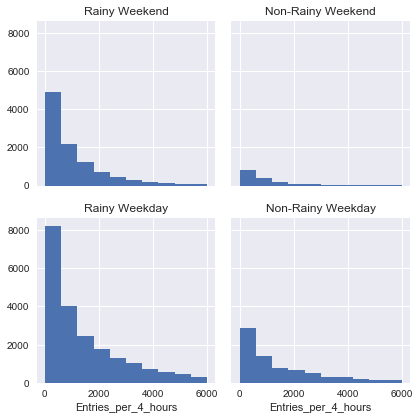

In [179]:
def rain_and_day_effect(dataframe):
    """
    Compare entries distribution between days of a week
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
        
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='rain', row='weekday')
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    axes = plot.axes.flatten()
    axes[0].set_title("Rainy Weekend")
    axes[1].set_title("Non-Rainy Weekend")
    axes[2].set_title("Rainy Weekday")
    axes[3].set_title("Non-Rainy Weekday")
    
    #Mann Whitney Test
    nrain_mean, rain_mean, U, p = [], [], [], []
    for i in range(2):
        daily_nrm, daily_rm, daily_U, daily_p = mann_whitney_plus_means \
        (dataframe[(dataframe['rain'] == 0) & (dataframe['weekday'] == i)]['Entries_per_4_hours'], 
         dataframe[(dataframe['rain'] == 1) & (dataframe['weekday'] == i)]['Entries_per_4_hours'])
        nrain_mean.append(daily_nrm)
        rain_mean.append(daily_rm)
        U.append(daily_U)
        p.append(daily_p)
    return nrain_mean, rain_mean, U, p

nrain_mean, rain_mean, U, p = rain_and_day_effect(nysw_df)
#plt.savefig('examples/rains_and_day.png')
plt.show()

Result from Then Mann Whitney Test is shown below.

In [180]:
print('On weekend')
print('---------------------------\n')
print('Average entries per 4 hours per turnstile on non-rainy weekend is %6.2f' %nrain_mean[0], '\n')
print('Average entries per 4 hours per turnstile on rainy weekend is %6.2f' %rain_mean[0], '\n')
print('The probability they are from the same distribution is %0.6f' %(p[0]*100),'%', '\n')
if p[0] <= 0.05:
    print('Therefore rain affects the ridership outcome on weekend')
else:
    print('Therefore rain does not affects the ridership outcome on weekend')

print('On weekday')
print('---------------------------\n')
print('Average entries per 4 hours per turnstile on non-rainy weekday is %6.2f' %nrain_mean[1], '\n')
print('Average entries per 4 hours per turnstile on rainy weekday is %6.2f' %rain_mean[1], '\n')
print('The probability they are from the same distribution is %0.6f' %(p[1]*100),'%', '\n')
if p[1] <= 0.05:
    print('Therefore rain affects the ridership outcome on weekday')
else:
    print('Therefore rain does not affects the ridership outcome on weekday')

On weekend
---------------------------

Average entries per 4 hours per turnstile on non-rainy weekend is 1226.06 

Average entries per 4 hours per turnstile on rainy weekend is 1091.61 

The probability they are from the same distribution is 2.196652 % 

Therefore rain affects the ridership outcome on weekend
On weekday
---------------------------

Average entries per 4 hours per turnstile on non-rainy weekday is 2133.57 

Average entries per 4 hours per turnstile on rainy weekday is 2227.96 

The probability they are from the same distribution is 5.326942 % 

Therefore rain does not affects the ridership outcome on weekday


Mann Whitney Test rejected the null hypothesis of weekend ridership data. It means that rain affect people's choice on riding subway. Null hypothesis of weekday ridership data isn't rejected, however it is close enough to the p-critical value that a interaction between weekday and rain features. 

#### How does fog affect the ridership?

Another hypothesis is that fog would also affect ridership. Similarly, histograms are shown below.

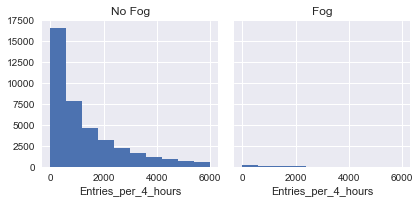

In [181]:
def fog_effect(dataframe):
    """
    Compare entries distribution between foggy days and non-foggy days
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
    
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='fog')
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    #plot.fig.suptitle('Compare Entries Distribution on foggy Days and Non foggy Days')
    axes = plot.axes.flatten()
    axes[0].set_title("No Fog")
    axes[1].set_title("Fog")
    
    #Mann Whitney Test
    nfog_mean, fog_mean, U, p = mann_whitney_plus_means(dataframe[dataframe['fog'] == 0]['Entries_per_4_hours'], 
                                                        dataframe[dataframe['fog'] == 1]['Entries_per_4_hours'])
    return nfog_mean, fog_mean, U, p


nfog_mean, fog_mean, U, p = fog_effect(nysw_df)
plt.show()

It is harder to visualized the fog effect than the rain effect, since there is even less foggy days. Therefore a two tailed Mann Whitney Test is used to exam the null hypothesis. Again the p-critical value is 5%. The result of the test is shown below.

In [182]:
print('Average entries per 4 hours per turnstile on non-foggy days is %6.2f' %nfog_mean, '\n')
print('Average entries per 4 hours per turnstile on foggy days is %6.2f' %fog_mean, '\n')
print('The probability that they from the same distribution is %0.6f' %(p*100),'%', '\n')
if p <= 0.05:
    print('Therefore fog affects the ridership outcome')
else:
    print('Therefore fog does not affects the ridership outcome')

Average entries per 4 hours per turnstile on non-foggy days is 1889.12 

Average entries per 4 hours per turnstile on foggy days is 1631.98 

The probability that they from the same distribution is 0.334419 % 

Therefore fog affects the ridership outcome


#### How does weekday/weekend affect the ridership?

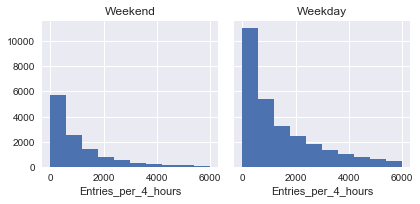

In [183]:
def weekday_effect(dataframe):
    """
    Compare entries distribution between weekday and weekend
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
    
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='weekday')
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    axes = plot.axes.flatten()
    axes[0].set_title("Weekend")
    axes[1].set_title("Weekday")
    
    #Mann Whitney Test
    weekend_mean, weekday_mean, U, p = mann_whitney_plus_means \
    (dataframe[dataframe['weekday'] == 0]['Entries_per_4_hours'], 
     dataframe[dataframe['weekday'] == 1]['Entries_per_4_hours'])
    return weekend_mean, weekday_mean, U, p

weekend_mean, weekday_mean, U, p = weekday_effect(nysw_df)
plt.show()


In [184]:
print('Average entries per 4 hours per turnstile on weekend is %6.2f' %weekend_mean, '\n')
print('Average entries per 4 hours per turnstile on weekday is %6.2f' %weekday_mean, '\n')
print('The probability that they are from the same distribution is %0.6f' %(p*100),'%', '\n')
if p <= 0.05:
    print('Therefore workday affects the ridership outcome')
else:
    print('Therefore workday does not affects the ridership outcome')

Average entries per 4 hours per turnstile on weekend is 1207.46 

Average entries per 4 hours per turnstile on weekday is 2158.04 

The probability that they are from the same distribution is 0.000000 % 

Therefore workday affects the ridership outcome


#### How does the time of a day affect the ridership?

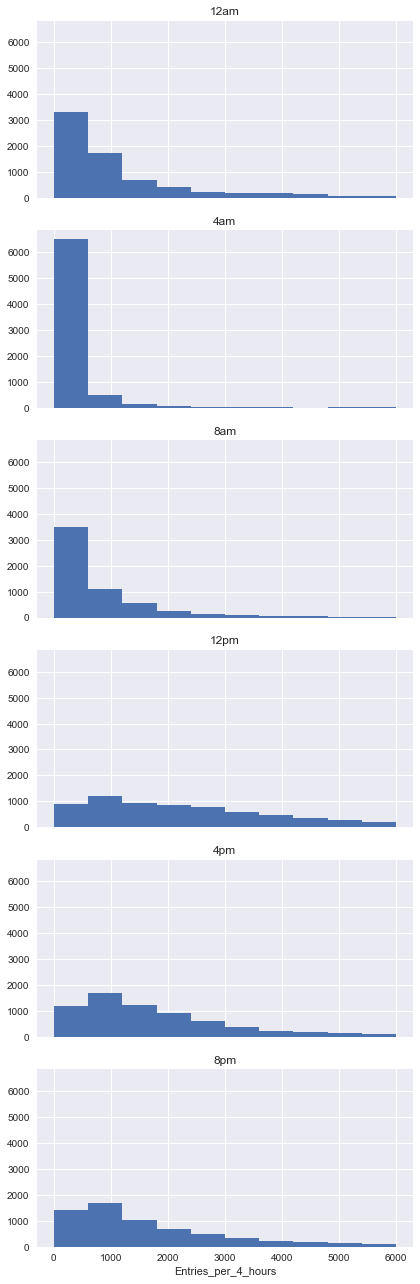

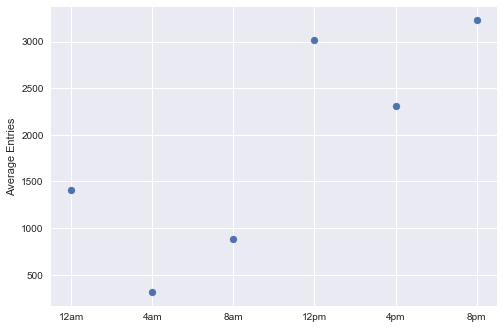

In [185]:
def time_effect(dataframe):
    """
    Compare entries distribution between days of a week
    Computer average entries for each time slot and plot them on a scatter plot
    """
    
    hour = ['12am', '4am', '8am', '12pm', '4pm', '8pm']
    #Plot distribution
    plot = sns.FacetGrid(dataframe, row='hour', size = 3, aspect = 2 )
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    axes = plot.axes.flatten()
    for i in range(len(axes)):
        axes[i].set_title(hour[i])
    #Compare average entries
    avg_by_time = dataframe[['hour', 'Entries_per_4_hours']].\
                    groupby(['hour'], as_index=False).mean().sort_values(by='hour')
    plt.figure()
    plt.scatter(avg_by_time['hour'],avg_by_time['Entries_per_4_hours'])
    plt.xticks(avg_by_time['hour'],hour)
    plt.ylabel('Average Entries')
    
time_effect(nysw_df)
#plt.savefig('examples/time.png')
plt.show()

Both the histograms and the scatter plots shows ridership has different behavior during different time of a day. The scatter shows that the time has no numerical values, thus time variable is treated as categorical and dummy features are created for them.

#### How does temperature affect the ridership?

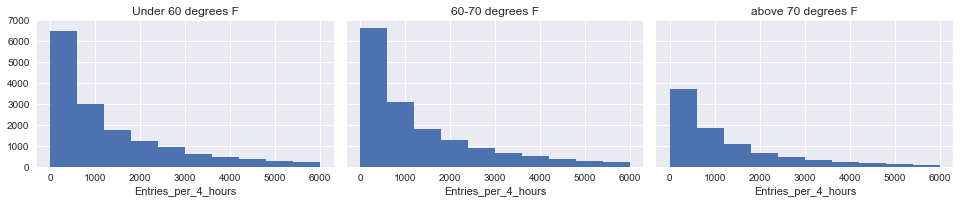

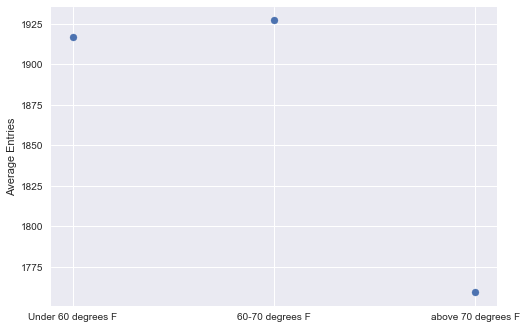

In [186]:
def temp_effect(dataframe):
    """
    Compare entries distribution between different temperature range
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
    temp = ['Under 60 degrees F', '60-70 degrees F', 'above 70 degrees F']
    
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='meantempi', aspect = 1.5)
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    axes = plot.axes.flatten()
    for i in range(len(axes)):
        axes[i].set_title(temp[i])
    
    #Compare average entries    
    avg_by_temp = dataframe[['meantempi', 'Entries_per_4_hours']].\
                    groupby(['meantempi'],as_index=False).mean().sort_values(by='meantempi')
    plt.figure()
    plt.scatter(avg_by_temp['meantempi'],avg_by_temp['Entries_per_4_hours']) 
    plt.xticks(avg_by_temp['meantempi'],temp)
    plt.ylabel('Average Entries')
    
temp_effect(nysw_df)
plt.show()


The scatter plot shows average entries for the days that is under 70 degree F are very similar. And it drops by about 200 entries when the temperature is above 70 degrees. Mann Whitney test is used to test if ridership distribution is different between the below 70 degree days and above 70 degree days.

In [187]:
chill_day_mean, hot_day_mean, U, p = mann_whitney_plus_means \
    (nysw_df[nysw_df['meantempi'] < 3]['Entries_per_4_hours'], 
     nysw_df[nysw_df['meantempi'] == 3]['Entries_per_4_hours'])

print('Average entries per 4 hours per turnstile when temperature is under 70 degree F is %6.2f' %chill_day_mean, '\n')
print('Average entries per 4 hours per turnstile when temperature is above 70 degree F is %6.2f' %hot_day_mean, '\n')
print('The probability that they are from the same distribution is %0.6f' %(p*100),'%', '\n')
if p <= 0.05:
    print('Therefore temperature affects the ridership outcome')
else:
    print('Therefore temperature does not affects the ridership outcome')

Average entries per 4 hours per turnstile when temperature is under 70 degree F is 1922.00 

Average entries per 4 hours per turnstile when temperature is above 70 degree F is 1759.28 

The probability that they are from the same distribution is 0.020301 % 

Therefore temperature affects the ridership outcome


#### How does windspeed affect the ridership?

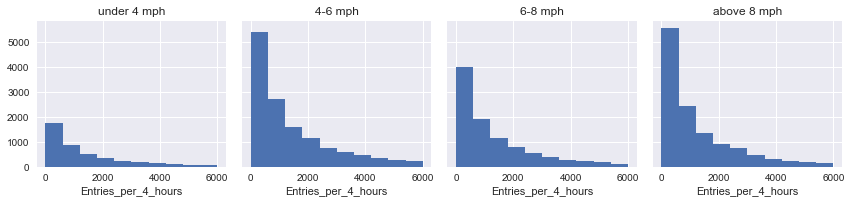

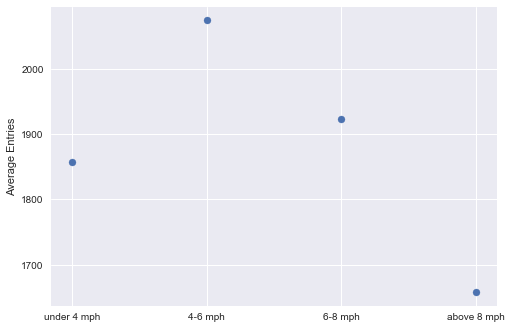

In [188]:
def wind_effect(dataframe):
    """
    Compare entries distribution between different wind speed
    Perform Mann Whitney Test to exam the null hypothesis
    Return mean for both distribution and probability to accept the hypothesis
    """
    
    wsp = ['under 4 mph', '4-6 mph', '6-8 mph', 'above 8 mph']
    
    #Plot distribution
    plot = sns.FacetGrid(dataframe, col='meanwspdi')
    plot.map(plt.hist, 'Entries_per_4_hours', range=[0,6000])
    axes = plot.axes.flatten()
    for i in range(len(axes)):
        axes[i].set_title(wsp[i])
    
    #Compare average entries     
    avg_by_wind = dataframe[['meanwspdi', 'Entries_per_4_hours']].groupby(['meanwspdi'], as_index=False).mean().sort_values(by='meanwspdi')
    plt.figure()
    plt.scatter(avg_by_wind['meanwspdi'],avg_by_wind['Entries_per_4_hours']) 
    plt.xticks(avg_by_wind['meanwspdi'],wsp) 
    plt.ylabel('Average Entries')


wind_effect(nysw_df)
plt.show()

In [189]:
normal_day_mean, windy_day_mean, U, p = mann_whitney_plus_means \
    (nysw_df[nysw_df['meanwspdi'] < 4]['Entries_per_4_hours'], 
     nysw_df[nysw_df['meanwspdi'] >= 4]['Entries_per_4_hours'])

print('Average entries per 4 hours per turnstile on non-windy days is %6.2f' %normal_day_mean, '\n')
print('Average entries per 4 hours per turnstile on windy days is %6.2f' %windy_day_mean, '\n')
print('The probability that they are from the same distribution is %0.6f' %(p*100),'%', '\n')
if p <= 0.05:
    print('Therefore wind affects the ridership outcome')
else:
    print('Therefore wind does not affects the ridership outcome')

Average entries per 4 hours per turnstile on non-windy days is 1987.14 

Average entries per 4 hours per turnstile on windy days is 1657.85 

The probability that they are from the same distribution is 0.000000 % 

Therefore wind affects the ridership outcome


### 4. Linear Regression
The next step is to develop a linear regression model to predict number of entries based on information we have.
For this project gradient decent is used to fit a linear model. Before gradient decent is applied all features are normalized. 

In [190]:
def plot_residuals(dataframe, predictions):
    '''
    a histogram of the residuals

    '''
    
    plt.figure()
    (dataframe['Entries_per_4_hours'] - predictions).hist(bins=500)
    plt.title('Residuals Distribution')
    plt.xlabel('Data - Prediction')
    #plt.savefig('examples/ResidualHist.png')
    plt.figure()
    plt.scatter(dataframe['Entries_per_4_hours'], dataframe['Entries_per_4_hours'] - predictions)
    plt.title('Data v.s. Residuals')
    plt.ylabel('Residuals')
    plt.xlabel('Data')
    #plt.savefig('examples/DataVSResiduals.png')
    #return plt
    
def compute_r_squared(dataframe, predictions):
    '''
    calculate the R^2 value
    '''
    data = np.array(dataframe['Entries_per_4_hours'])
    ssr=(np.square(predictions - np.mean(predictions))).sum()
    sst=(np.square(data-np.mean(data))).sum()
    r_squared = ssr/sst
    return r_squared

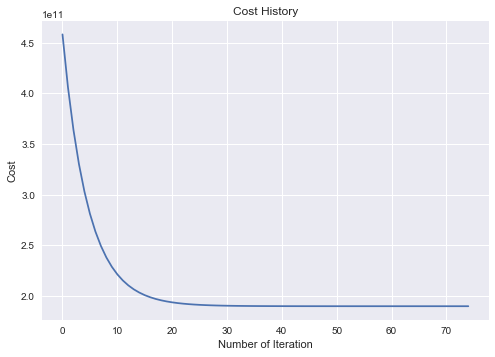

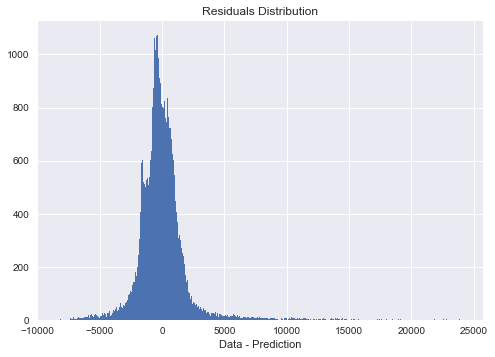

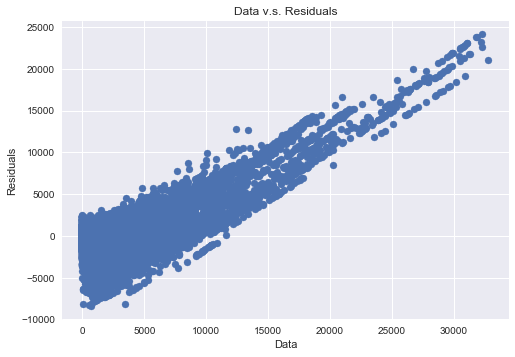


R-Squared is
0.488592964509


In [191]:
nysw_df['rain_day'] = nysw_df['rain'] * nysw_df['weekday']
nysw_df['meanwspdi_sq'] = nysw_df['meanwspdi'] ** 2

features = ['weekday', 'rain', 'rain_day','meanwspdi_sq', 'meanprecipi', 'meanwspdi']
pred = predictions(nysw_df, features)
plot_residuals(nysw_df, pred)
plt.show()

print()
print('R-Squared is')
print(compute_r_squared(nysw_df, pred))


## Conclusion

The final R squared value is 0.4886. 
The cost history trends shows that the cost stop decreasing after 20 iterations, and cost stays at a fairly high value. It suggeust the model is underfitted. The scatter plot of real data and residual shows a pattern instead of random distribution suggested that linear model is not the best model to fit this data. Or there could be other important features missing. 

Future improvement includes examing different regression model, and/or include more features.


